# Dane

### Pytania do tej części:

* Czy normalizować Amount (robię to)
* Czy usuwać Time (nie robię tego)
* Czy można jakoś lepiej dzielić zbiór na 10 części (KFold robi zbyt po kolei, może najpierw spermutować dane?)

In [1]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
import itertools
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report
from itertools import cycle
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV

import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-5.3.0-posix-seh-rt_v4-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
import xgboost as xgb

C:\Users\Marta\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Marta\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
from imblearn.ensemble import EasyEnsemble
from imblearn.over_sampling import SMOTE

In [7]:
sciezka = "C:/Users/Marta/Desktop/wb 3/"
dane = pd.read_csv(sciezka+"creditcard.csv")
dane['normAmount'] = StandardScaler().fit_transform(dane['Amount'].reshape(-1, 1))
dane2 = dane.drop(['Amount'],axis=1)
y = dane2.Class
X = dane2.drop('Class', 1)
dane2.head()

C:\Users\Marta\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


In [13]:
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
kf = KFold(n_splits=10)
numery = np.ones(284807)


[ 1.  1.  1. ...,  1.  1.  1.]


Narzędzie do rysowania confusion matrix (ściągnięte)

In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## 1. Model logistyczny

### Pytania do tej części:

* Czy dodawać sztucznie wyraz wolny (nie robię tego)
* Które wykresy zostawić?
* Na co się patrzeć jako miarę dopasowania


* POMYSŁ: może zapisywać pstwa do osobnego wektora (coraz dłuższy) żeby w końcu mieć wyestymowane pstwa całego zbioru, a potem jakoś na tym działać
* OGÓLNIE: chyba nie ma sensu rysować ROC, bo wszystkie wyglądają tak samo, ograniczyłabym się tylko do wykresów zagregowanych (na tym wetorze, który wprowadzę i na zsumowanej macierzy dopasowania)

## A. Model logistyczny - undersampling

In [52]:
cnf_matrix2=[[0, 0],[0, 0]]

Wymiar zbioru treningowego: (256326,) Wymiar zbioru testowego: (28481,)
Recall metric in the testing dataset:  0.989247311828


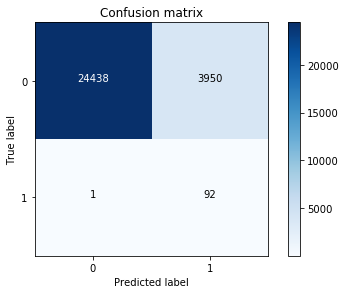

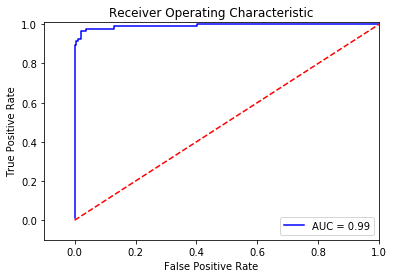

Wymiar zbioru treningowego: (256326,) Wymiar zbioru testowego: (28481,)
Recall metric in the testing dataset:  0.953125


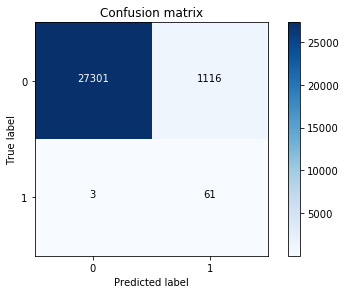

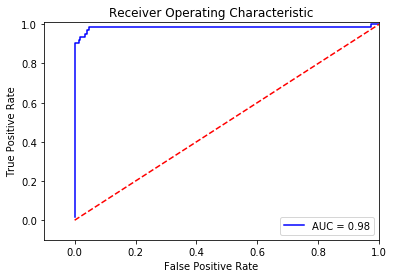

Wymiar zbioru treningowego: (256326,) Wymiar zbioru testowego: (28481,)
Recall metric in the testing dataset:  0.851063829787


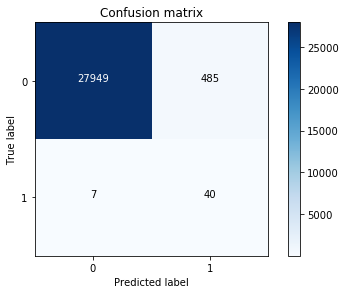

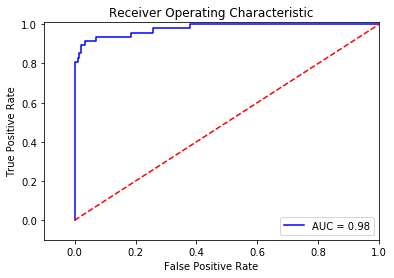

Wymiar zbioru treningowego: (256326,) Wymiar zbioru testowego: (28481,)
Recall metric in the testing dataset:  0.783783783784


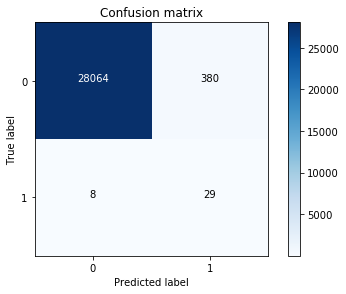

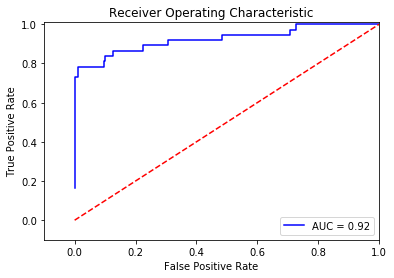

Wymiar zbioru treningowego: (256326,) Wymiar zbioru testowego: (28481,)
Recall metric in the testing dataset:  0.857142857143


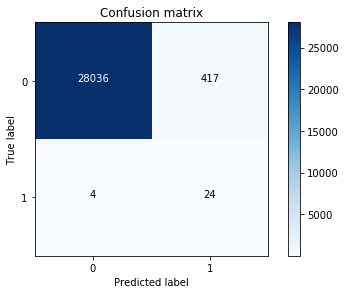

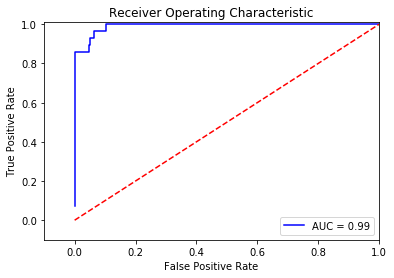

Wymiar zbioru treningowego: (256326,) Wymiar zbioru testowego: (28481,)
Recall metric in the testing dataset:  0.923076923077


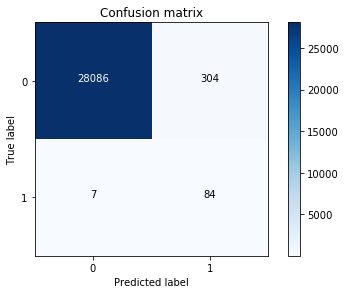

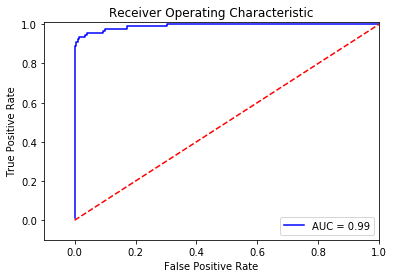

Wymiar zbioru treningowego: (256326,) Wymiar zbioru testowego: (28481,)
Recall metric in the testing dataset:  0.833333333333


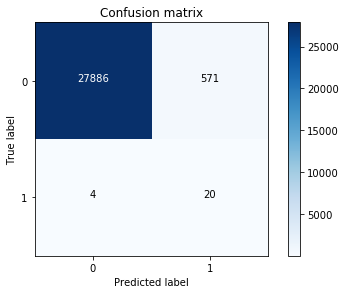

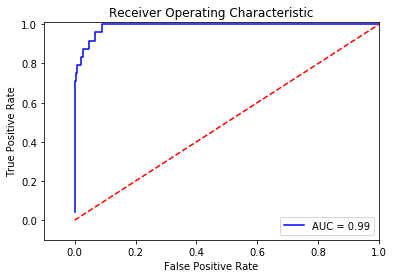

Wymiar zbioru treningowego: (256327,) Wymiar zbioru testowego: (28480,)
Recall metric in the testing dataset:  0.848484848485


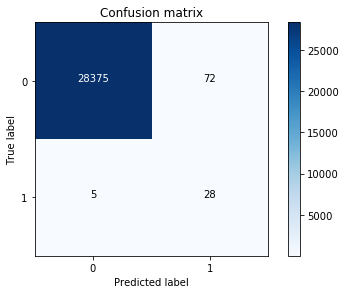

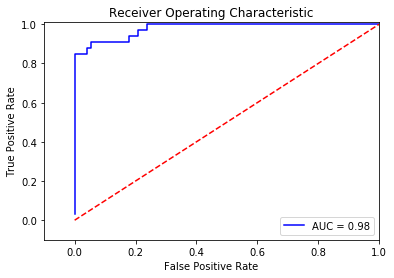

Wymiar zbioru treningowego: (256327,) Wymiar zbioru testowego: (28480,)
Recall metric in the testing dataset:  0.792452830189


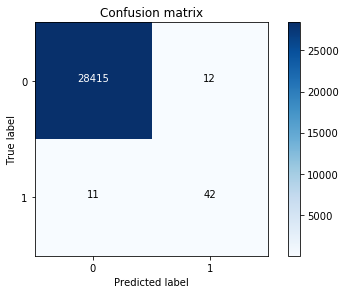

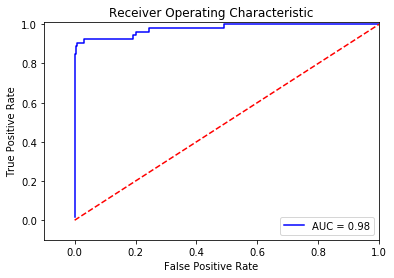

Wymiar zbioru treningowego: (256327,) Wymiar zbioru testowego: (28480,)
Recall metric in the testing dataset:  0.818181818182


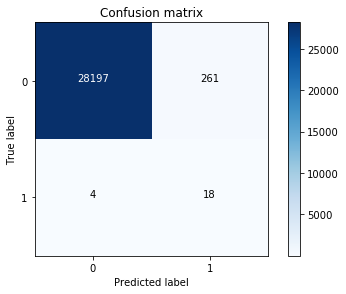

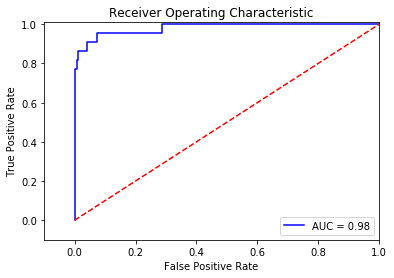

In [60]:
for train, test in kf.split(numery):
   print("Wymiar zbioru treningowego:", train.shape, "Wymiar zbioru testowego:", test.shape)
   X_train=X.ix[train]
   X_test=X.ix[test]
   y_train=y.ix[train]
   y_test=y.ix[test]
   n_fraud_train = sum(y_train == 1) 
   class_1_indices = np.array(X_train[y_train == 1].index)
   class_0_indices = np.array(X_train[y_train == 0].index) 
   class_0_indices = np.array(np.random.choice(class_0_indices, n_fraud_train, replace = False))
   indexy = np.concatenate([class_1_indices, class_0_indices])
   X_train_under = X_train.loc[indexy]
   y_train_under = y_train.loc[indexy]
    
    #teraz model
   model = LogisticRegression()
   model = model.fit(X_train_under, y_train_under)
   predicted = model.predict(X_test)

   cnf_matrix = metrics.confusion_matrix(y_test,predicted)
   cnf_matrix2 = cnf_matrix2 + cnf_matrix
   
   print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
   class_names = [0,1]
   plt.figure()
   plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
   plt.show()

  # ROC CURVE
   predicted2 = model.fit(X_train_under,y_train_under.values.ravel()).decision_function(X_test.values)
   fpr, tpr, thresholds = roc_curve(y_test,predicted2)
   roc_auc = auc(fpr,tpr)
   plt.title('Receiver Operating Characteristic')
   plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
   plt.legend(loc='lower right')
   plt.plot([0,1],[0,1],'r--')
   plt.xlim([-0.1,1.0])
   plt.ylim([-0.1,1.01])
   plt.ylabel('True Positive Rate')
   plt.xlabel('False Positive Rate')
   plt.show()


[[277028   7287]
 [    56    436]]
Recall metric in the testing dataset:  0.886178861789


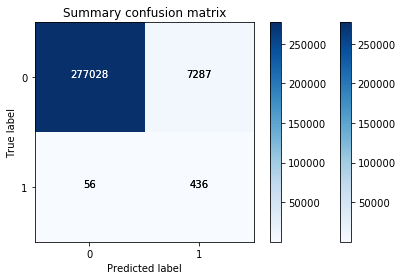

In [58]:
#rysujemy zsumowaną confusion matrix
print(cnf_matrix2)
print("Recall metric in the testing dataset: ", cnf_matrix2[1,1]/(cnf_matrix2[1,0]+cnf_matrix2[1,1]))
plot_confusion_matrix(cnf_matrix2, classes=class_names, title='Summary confusion matrix')
plt.show()

## B. Model logistyczny - SMOTE
   

Wymiar zbioru treningowego: (256326,) Wymiar zbioru testowego: (28481,)
Recall metric in the testing dataset:  0.978494623656


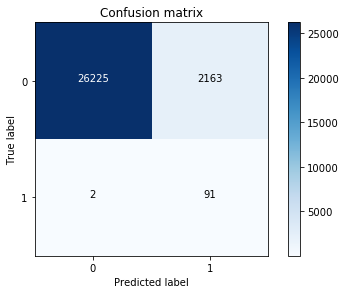

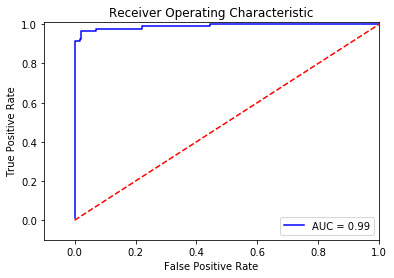

Wymiar zbioru treningowego: (256326,) Wymiar zbioru testowego: (28481,)
Recall metric in the testing dataset:  0.9375


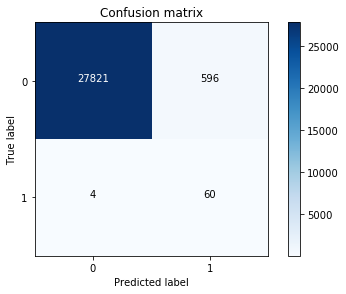

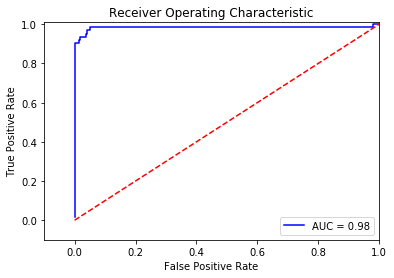

Wymiar zbioru treningowego: (256326,) Wymiar zbioru testowego: (28481,)
Recall metric in the testing dataset:  0.851063829787


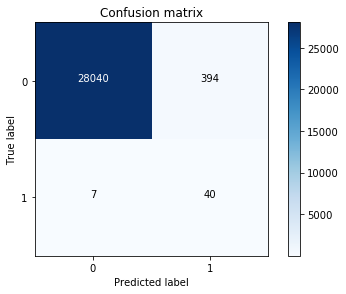

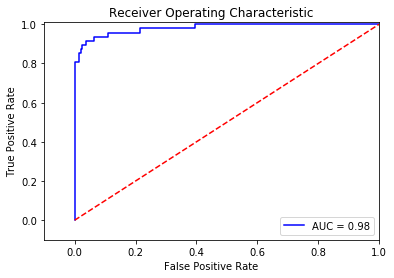

Wymiar zbioru treningowego: (256326,) Wymiar zbioru testowego: (28481,)
Recall metric in the testing dataset:  0.783783783784


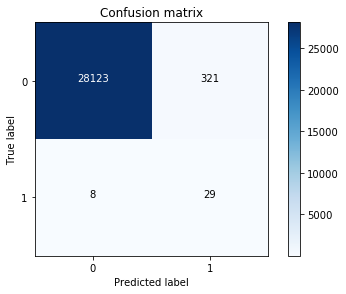

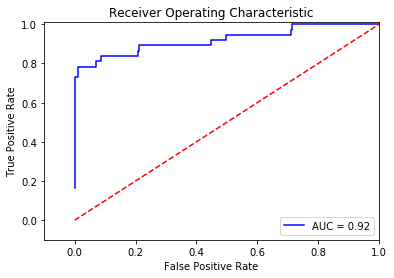

Wymiar zbioru treningowego: (256326,) Wymiar zbioru testowego: (28481,)
Recall metric in the testing dataset:  0.857142857143


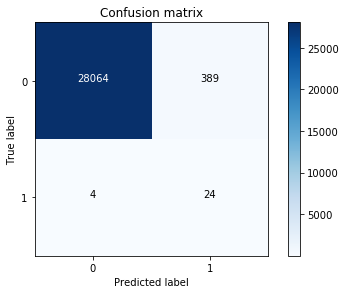

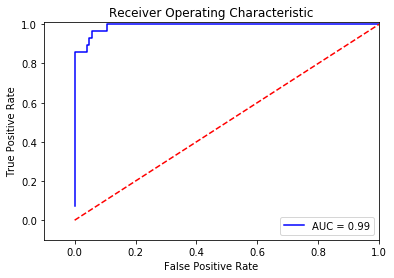

Wymiar zbioru treningowego: (256326,) Wymiar zbioru testowego: (28481,)
Recall metric in the testing dataset:  0.912087912088


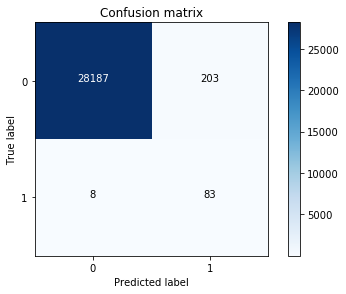

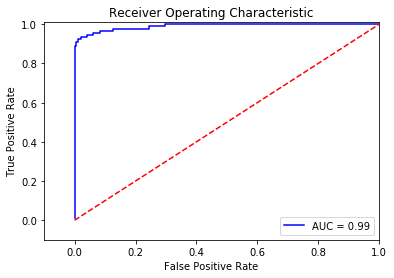

Wymiar zbioru treningowego: (256326,) Wymiar zbioru testowego: (28481,)
Recall metric in the testing dataset:  0.708333333333


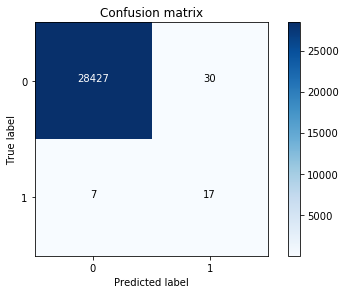

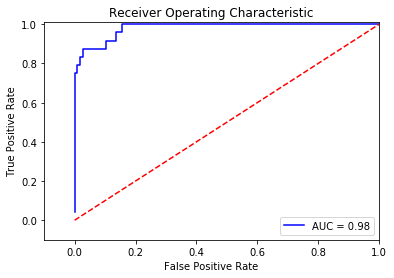

Wymiar zbioru treningowego: (256327,) Wymiar zbioru testowego: (28480,)
Recall metric in the testing dataset:  0.818181818182


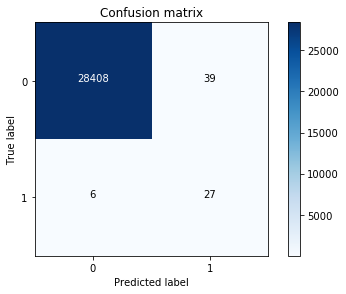

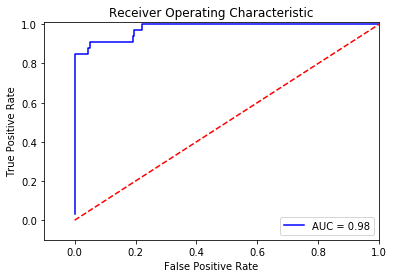

Wymiar zbioru treningowego: (256327,) Wymiar zbioru testowego: (28480,)
Recall metric in the testing dataset:  0.811320754717


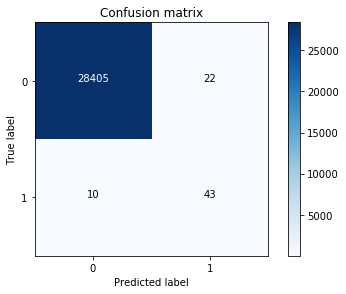

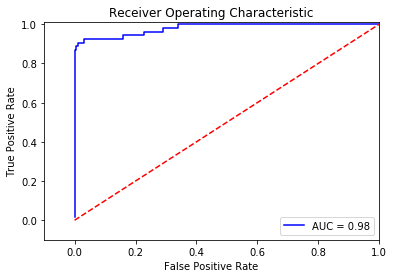

Wymiar zbioru treningowego: (256327,) Wymiar zbioru testowego: (28480,)
Recall metric in the testing dataset:  0.727272727273


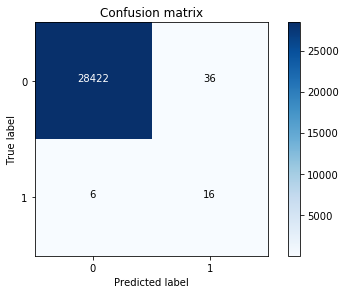

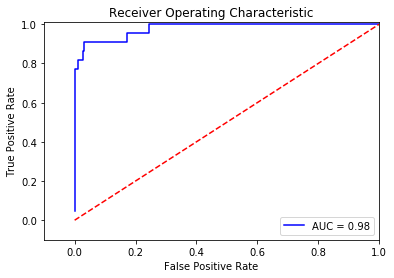

In [61]:
cnf_matrix2=[[0, 0],[0, 0]]

for train, test in kf.split(numery):
   print("Wymiar zbioru treningowego:", train.shape, "Wymiar zbioru testowego:", test.shape)
   X_train=X.ix[train]
   X_test=X.ix[test]
   y_train=y.ix[train]
   y_test=y.ix[test]
   sm = SMOTE(kind='regular', k_neighbors=10) 
   X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)
   X_train_smote = pd.DataFrame(X_train_smote, columns=X_train.columns)
   y_train_smote = pd.Series(y_train_smote)
    
    #teraz model
   model = LogisticRegression()
   model = model.fit(X_train_smote, y_train_smote)
   predicted = model.predict(X_test)

   cnf_matrix = metrics.confusion_matrix(y_test,predicted)
   cnf_matrix2 = cnf_matrix2 + cnf_matrix
   
   print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
   class_names = [0,1]
   plt.figure()
   plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
   plt.show()

  # ROC CURVE
   predicted2 = model.fit(X_train_smote,y_train_smote.values.ravel()).decision_function(X_test.values)
   fpr, tpr, thresholds = roc_curve(y_test,predicted2)
   roc_auc = auc(fpr,tpr)
   plt.title('Receiver Operating Characteristic')
   plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
   plt.legend(loc='lower right')
   plt.plot([0,1],[0,1],'r--')
   plt.xlim([-0.1,1.0])
   plt.ylim([-0.1,1.01])
   plt.ylabel('True Positive Rate')
   plt.xlabel('False Positive Rate')
   plt.show()


[[280122   4193]
 [    62    430]]
Recall metric in the testing dataset:  0.873983739837


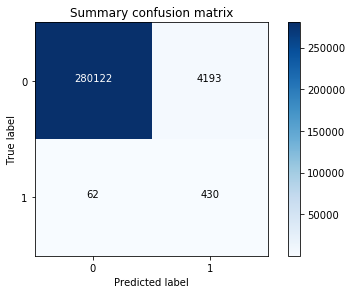

In [63]:
#rysujemy zsumowaną confusion matrix
print(cnf_matrix2)
print("Recall metric in the testing dataset: ", cnf_matrix2[1,1]/(cnf_matrix2[1,0]+cnf_matrix2[1,1]))
plot_confusion_matrix(cnf_matrix2, classes=class_names, title='Summary confusion matrix')
plt.show()

## C. Model logistyczny - Easy Ensemble

...

# 2. Lasy losowe

### Pytania do tej części:


* Jak wcześniej - jak teraz do tego dorzucić różne progi
* Tutaj krzywa ROC rysuje się inaczej, czy tak jest dobrze?

## A. Lasy losowe - undersampling

Wymiar zbioru treningowego: (256326,) Wymiar zbioru testowego: (28481,)
Recall metric in the testing dataset:  0.94623655914


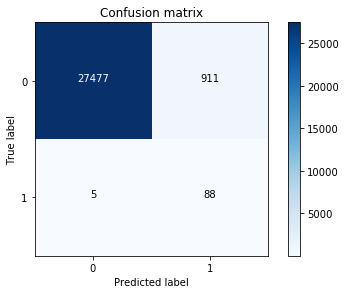

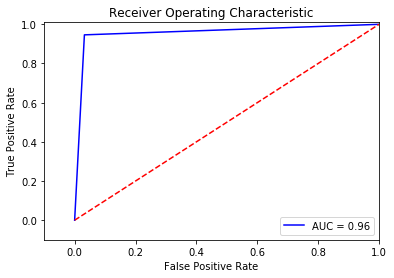

Wymiar zbioru treningowego: (256326,) Wymiar zbioru testowego: (28481,)
Recall metric in the testing dataset:  0.921875


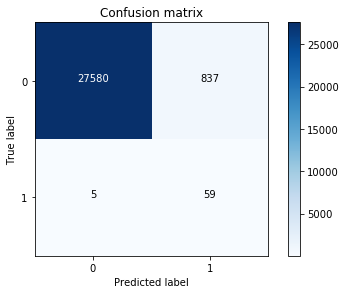

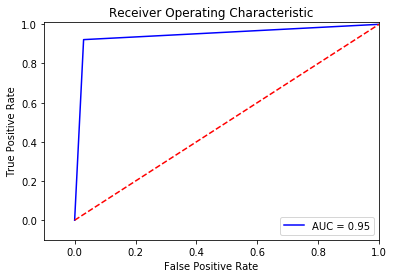

Wymiar zbioru treningowego: (256326,) Wymiar zbioru testowego: (28481,)
Recall metric in the testing dataset:  0.829787234043


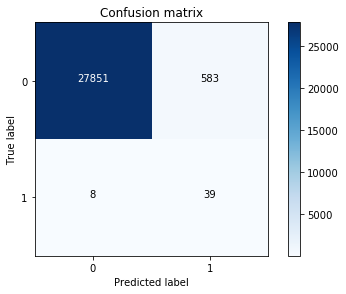

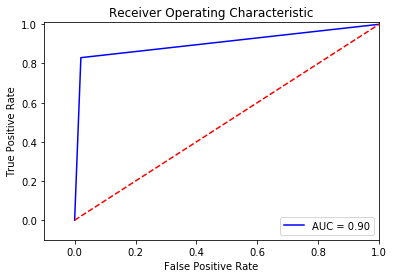

Wymiar zbioru treningowego: (256326,) Wymiar zbioru testowego: (28481,)
Recall metric in the testing dataset:  0.810810810811


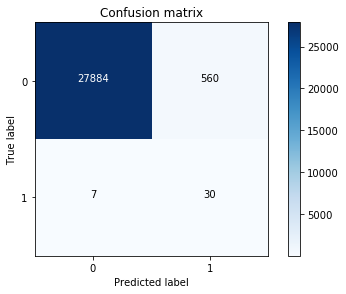

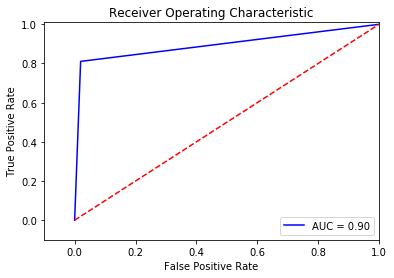

Wymiar zbioru treningowego: (256326,) Wymiar zbioru testowego: (28481,)
Recall metric in the testing dataset:  0.857142857143


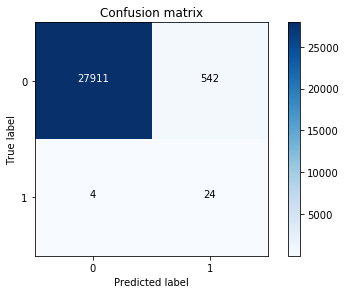

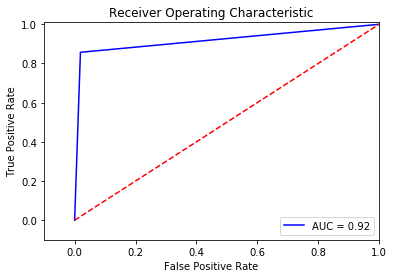

Wymiar zbioru treningowego: (256326,) Wymiar zbioru testowego: (28481,)
Recall metric in the testing dataset:  0.923076923077


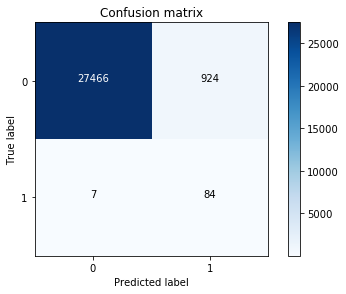

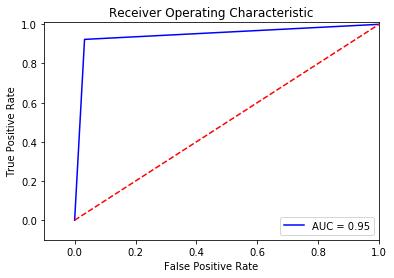

Wymiar zbioru treningowego: (256326,) Wymiar zbioru testowego: (28481,)
Recall metric in the testing dataset:  0.833333333333


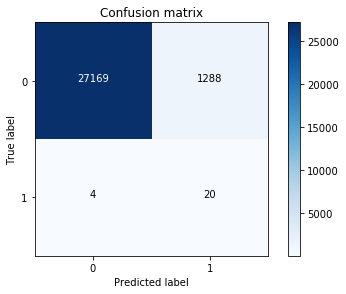

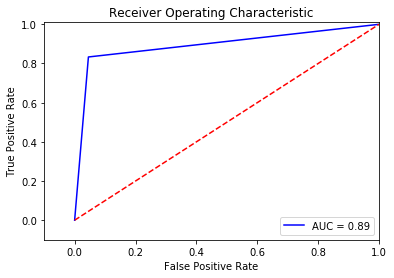

Wymiar zbioru treningowego: (256327,) Wymiar zbioru testowego: (28480,)
Recall metric in the testing dataset:  0.878787878788


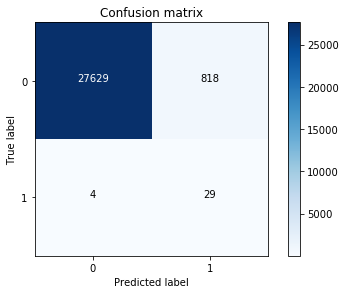

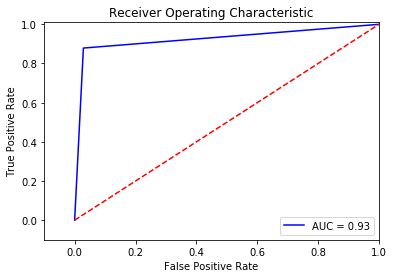

Wymiar zbioru treningowego: (256327,) Wymiar zbioru testowego: (28480,)
Recall metric in the testing dataset:  0.905660377358


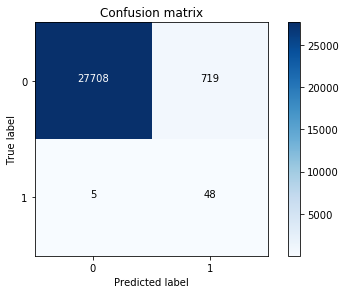

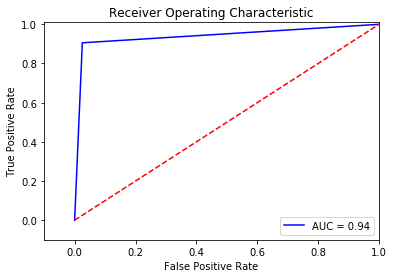

Wymiar zbioru treningowego: (256327,) Wymiar zbioru testowego: (28480,)
Recall metric in the testing dataset:  0.772727272727


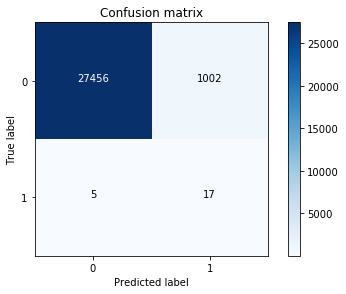

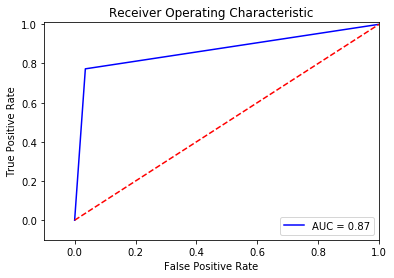

In [66]:
cnf_matrix2=[[0, 0],[0, 0]]
for train, test in kf.split(numery):
   print("Wymiar zbioru treningowego:", train.shape, "Wymiar zbioru testowego:", test.shape)
   X_train=X.ix[train]
   X_test=X.ix[test]
   y_train=y.ix[train]
   y_test=y.ix[test]
   n_fraud_train = sum(y_train == 1) 
   class_1_indices = np.array(X_train[y_train == 1].index)
   class_0_indices = np.array(X_train[y_train == 0].index) 
   class_0_indices = np.array(np.random.choice(class_0_indices, n_fraud_train, replace = False))
   indexy = np.concatenate([class_1_indices, class_0_indices])
   X_train_under = X_train.loc[indexy]
   y_train_under = y_train.loc[indexy]
    
    #teraz model
   model = RandomForestClassifier()
   model = model.fit(X_train_under, y_train_under)
   predicted = model.predict(X_test)

   cnf_matrix = metrics.confusion_matrix(y_test,predicted)
   cnf_matrix2 = cnf_matrix2 + cnf_matrix
   
   print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
   class_names = [0,1]
   plt.figure()
   plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
   plt.show()

  # ROC CURVE
   fpr, tpr, thresholds = roc_curve(y_test,predicted)
   roc_auc = auc(fpr,tpr)
   plt.title('Receiver Operating Characteristic')
   plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
   plt.legend(loc='lower right')
   plt.plot([0,1],[0,1],'r--')
   plt.xlim([-0.1,1.0])
   plt.ylim([-0.1,1.01])
   plt.ylabel('True Positive Rate')
   plt.xlabel('False Positive Rate')
   plt.show()

[[276131   8184]
 [    54    438]]
Recall metric in the testing dataset:  0.890243902439


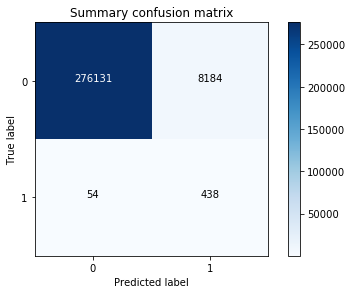

In [67]:
#rysujemy zsumowaną confusion matrix
print(cnf_matrix2)
print("Recall metric in the testing dataset: ", cnf_matrix2[1,1]/(cnf_matrix2[1,0]+cnf_matrix2[1,1]))
plot_confusion_matrix(cnf_matrix2, classes=class_names, title='Summary confusion matrix')
plt.show()

## B. Lasy losowe - SMOTE

In [ ]:
cnf_matrix2=[[0, 0],[0, 0]]

for train, test in kf.split(numery):
   print("Wymiar zbioru treningowego:", train.shape, "Wymiar zbioru testowego:", test.shape)
   X_train=X.ix[train]
   X_test=X.ix[test]
   y_train=y.ix[train]
   y_test=y.ix[test]
   sm = SMOTE(kind='regular', k_neighbors=10) 
   X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)
   X_train_smote = pd.DataFrame(X_train_smote, columns=X_train.columns)
   y_train_smote = pd.Series(y_train_smote)
    
    #teraz model
   model = RandomForestClassifier()
   model = model.fit(X_train_smote, y_train_smote)
   predicted = model.predict(X_test)

   cnf_matrix = metrics.confusion_matrix(y_test,predicted)
   cnf_matrix2 = cnf_matrix2 + cnf_matrix
   
   print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
   class_names = [0,1]
   plt.figure()
   plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
   plt.show()


In [ ]:
#rysujemy zsumowaną confusion matrix
print(cnf_matrix2)
print("Recall metric in the testing dataset: ", cnf_matrix2[1,1]/(cnf_matrix2[1,0]+cnf_matrix2[1,1]))
plot_confusion_matrix(cnf_matrix2, classes=class_names, title='Summary confusion matrix')
plt.show()

## C. Lasy losowe - Easy Ensemble

# 3. XG Boost

### Pytania do tej części:


* Jak dobierać parametry do XGBoost'a?
* Zainstalowanie xgboost to był horror, może jest jakiś szybszy sposób

## A. XGBoost - undersampling


Wymiar zbioru treningowego: (256326,) Wymiar zbioru testowego: (28481,)
Recall metric in the testing dataset:  0.967741935484


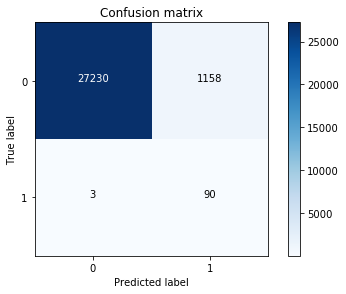

Wymiar zbioru treningowego: (256326,) Wymiar zbioru testowego: (28481,)
Recall metric in the testing dataset:  0.921875


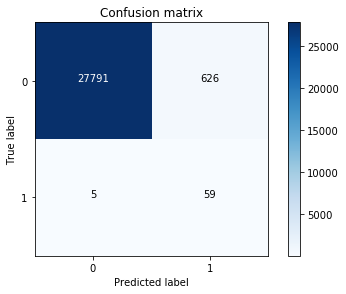

Wymiar zbioru treningowego: (256326,) Wymiar zbioru testowego: (28481,)
Recall metric in the testing dataset:  0.851063829787


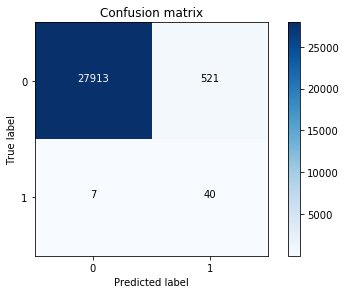

Wymiar zbioru treningowego: (256326,) Wymiar zbioru testowego: (28481,)
Recall metric in the testing dataset:  0.810810810811


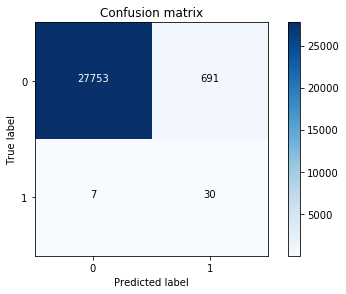

Wymiar zbioru treningowego: (256326,) Wymiar zbioru testowego: (28481,)
Recall metric in the testing dataset:  0.857142857143


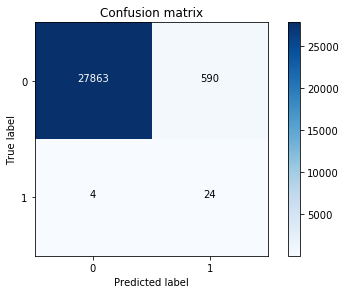

Wymiar zbioru treningowego: (256326,) Wymiar zbioru testowego: (28481,)
Recall metric in the testing dataset:  0.967032967033


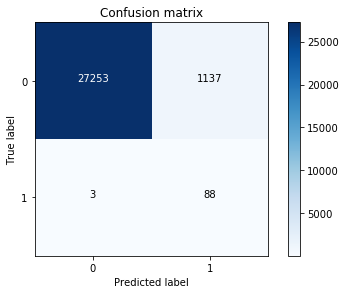

Wymiar zbioru treningowego: (256326,) Wymiar zbioru testowego: (28481,)
Recall metric in the testing dataset:  0.875


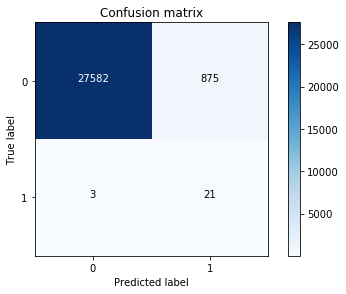

Wymiar zbioru treningowego: (256327,) Wymiar zbioru testowego: (28480,)
Recall metric in the testing dataset:  0.878787878788


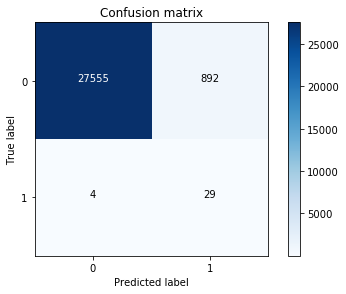

Wymiar zbioru treningowego: (256327,) Wymiar zbioru testowego: (28480,)
Recall metric in the testing dataset:  0.924528301887


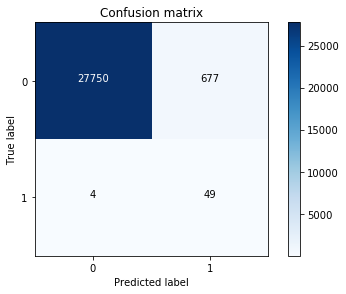

Wymiar zbioru treningowego: (256327,) Wymiar zbioru testowego: (28480,)
Recall metric in the testing dataset:  0.772727272727


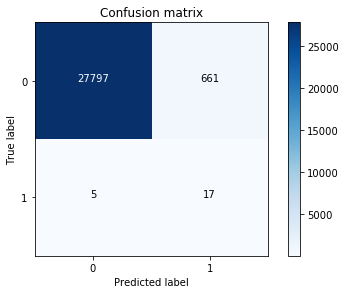

In [71]:
cnf_matrix2=[[0, 0],[0, 0]]
for train, test in kf.split(numery):
   print("Wymiar zbioru treningowego:", train.shape, "Wymiar zbioru testowego:", test.shape)
   X_train=X.ix[train]
   X_test=X.ix[test]
   y_train=y.ix[train]
   y_test=y.ix[test]
   n_fraud_train = sum(y_train == 1) 
   class_1_indices = np.array(X_train[y_train == 1].index)
   class_0_indices = np.array(X_train[y_train == 0].index) 
   class_0_indices = np.array(np.random.choice(class_0_indices, n_fraud_train, replace = False))
   indexy = np.concatenate([class_1_indices, class_0_indices])
   X_train_under = X_train.loc[indexy]
   y_train_under = y_train.loc[indexy]
    
    #teraz model
   model = xgb.XGBClassifier(max_depth=3, n_estimators=100, learning_rate=0.05)
   model = model.fit(X_train_under, y_train_under)
   predicted = model.predict(X_test)

   cnf_matrix = metrics.confusion_matrix(y_test,predicted)
   cnf_matrix2 = cnf_matrix2 + cnf_matrix
   
   print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
   class_names = [0,1]
   plt.figure()
   plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
   plt.show()


[[276487   7828]
 [    45    447]]
Recall metric in the testing dataset:  0.908536585366


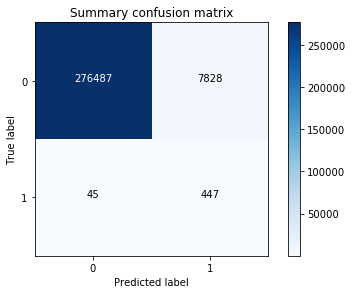

In [72]:
#rysujemy zsumowaną confusion matrix
print(cnf_matrix2)
print("Recall metric in the testing dataset: ", cnf_matrix2[1,1]/(cnf_matrix2[1,0]+cnf_matrix2[1,1]))
plot_confusion_matrix(cnf_matrix2, classes=class_names, title='Summary confusion matrix')
plt.show()

## B. XGBoost - SMOTE

In [ ]:
cnf_matrix2=[[0, 0],[0, 0]]

for train, test in kf.split(numery):
   print("Wymiar zbioru treningowego:", train.shape, "Wymiar zbioru testowego:", test.shape)
   X_train=X.ix[train]
   X_test=X.ix[test]
   y_train=y.ix[train]
   y_test=y.ix[test]
   sm = SMOTE(kind='regular', k_neighbors=10) 
   X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)
   X_train_smote = pd.DataFrame(X_train_smote, columns=X_train.columns)
   y_train_smote = pd.Series(y_train_smote)
    
    #teraz model
   model = xgb.XGBClassifier(max_depth=3, n_estimators=100, learning_rate=0.05)
   model = model.fit(X_train_smote, y_train_smote)
   predicted = model.predict(X_test)

   cnf_matrix = metrics.confusion_matrix(y_test,predicted)
   cnf_matrix2 = cnf_matrix2 + cnf_matrix
   
   print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
   class_names = [0,1]
   plt.figure()
   plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
   plt.show()

Wymiar zbioru treningowego: (256326,) Wymiar zbioru testowego: (28481,)


In [ ]:
#rysujemy zsumowaną confusion matrix
print(cnf_matrix2)
print("Recall metric in the testing dataset: ", cnf_matrix2[1,1]/(cnf_matrix2[1,0]+cnf_matrix2[1,1]))
plot_confusion_matrix(cnf_matrix2, classes=class_names, title='Summary confusion matrix')
plt.show()